<a href="https://colab.research.google.com/github/tmontaj/scripter/blob/main/Notebooks/WER_and_LER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Levenshtein distance**

Informally, the Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

\+ 

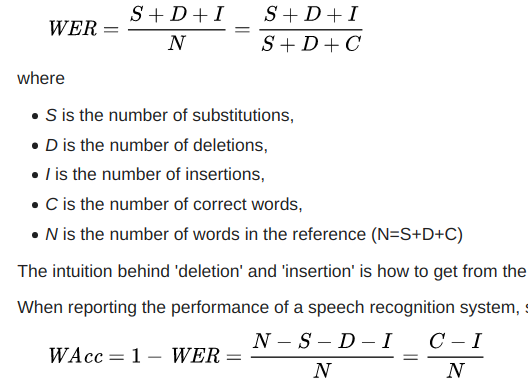

This means that if we have Levenshtein distance (LD) we could use it as I + D + s, and from legnth of the input we could get N.


However we could leave N to be an input as true lables are usually padded. 

In other words the function inputs should be (label, logits, label_length) 

shapes are:
- true_label [batch, max_label_steps]
- logits [batch, max_logit_steps]
- label_length [batch,]


In [ ]:
import nltk
import numpy as np
import tensorflow as tf


In [ ]:
word1 = np.array([25, 3,22,300])
word2 = np.array([25, 4,22,200,300])

In [ ]:
nltk.edit_distance(word1, word2, transpositions=False)

2

In [280]:
def object_error_rate(obj1, obj2):
  distance = nltk.edit_distance(obj1, obj2, transpositions=False)
  len_ = obj1.shape[0]
  return distance/len_

In [281]:
object_error_rate(word2, word1)

0.6666666666666666

In [267]:
class LER (tf.keras.metrics.Metric):
  def __init__(self, object_error_rate,name="LER", **kwargs):
    super(LER, self).__init__(name=name, **kwargs)
    self.error_rate = object_error_rate
    self.total = 0.0

  def update_state(self, y_true, y_pred, sample_weight=None):
    total=0
    for i in range(y_true.shape[0]):
      len_y_true = y_true[i][0]
      y_true_ = y_true[i][1:len_y_true+1]
      total+=self.calc_ler(y_true_, y_pred[i])
    
    self.total=total/y_true.shape[0]
    return self.total
        
  def result(self):return self.total

  def calc_ler(self, y_true, y_pred):
    print(y_true)
    return self.error_rate(y_true, y_pred)

  def reset_states(self):
    self.total = 0.0

In [268]:
x = LER(object_error_rate)

In [269]:
word1 = np.array([4, 25, 3,22,300])
word2 = np.array([25, 4,22,200,300])

batch1 = np.array([word1])
batch2 = np.array([word2])

In [270]:
batch1

array([[  4,  25,   3,  22, 300]])

In [271]:
batch2

array([[ 25,   4,  22, 200, 300]])

In [272]:
x.update_state(batch1, batch2)

[ 25   3  22 300]


0.25

In [273]:
word1 = np.array([[25, 3],[22],[300]])
word2 = np.array([[25, 4],[22],[200],[300]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [274]:
word1 = np.array([9,1,2,25,12,2,4,25,6,7,9,9,9])
word2 = np.array([3,2,25,12,2,4,25,6,8])

batch1 = np.array([word1])
batch2 = np.array([word2])

In [296]:
word1x = [[1,2],[25,12,2,4],[25,6,7]]
word2x = [[1,2],[25,12,2,4],[25,6,8]]

nltk.edit_distance(word1, word2, transpositions=False)
# type(word1x[0])

6

In [276]:
space = np.argwhere(word1==25)
np.split(word1, space.squeeze())

[array([9, 1, 2]), array([25, 12,  2,  4]), array([25,  6,  7,  9,  9,  9])]

In [385]:
class WER (tf.keras.metrics.Metric):
  def __init__(self, object_error_rate, space=25, name="LER", **kwargs):
    super(WER, self).__init__(name=name, **kwargs)
    self.error_rate = object_error_rate
    self.total = 0.0
    self.space = space
    # self.vnp2list = np.vectorize(self.np2list)

  def update_state(self, y_true, y_pred, sample_weight=None):
    total=0
    for i in range(y_true.shape[0]):
      space = np.argwhere(y_pred[i]==self.space)
      y_pred_ = np.split(y_pred[i], space.squeeze())

      space = np.argwhere(y_true[i]==self.space)
      len_y_true = y_true[i][0]
      y_true_ = y_true[i][:len_y_true+1]
      y_true_ = np.split(y_true_, space.squeeze())
      y_true_[0] = np.delete(y_true_[0], [0], axis=0)

      total+=self.calc_wer(y_true_, y_pred_)

    self.total=total/y_true.shape[0]
    return self.total

  def result(self):return self.total
  
  def np2list(self, np_arr): return np.array([i.tolist() for i in np_arr])

  def calc_wer(self, y_true, y_pred):
    y_true = self.np2list(y_true)
    y_pred = self.np2list(y_pred)
    return self.error_rate(y_true, y_pred)

  def reset_states(self):
    self.total = 0.0

In [386]:
x = WER(object_error_rate)

In [387]:
x.update_state(batch1, batch2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/autograph/impl/api.py:390: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return py_builtins.overload_of(f)(*args)


0.6666666666666666